In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from darksky import forecast
import datetime as dt
#from noaa_sdk import noaa
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import pickle
from shapely.geometry import Point, Polygon

#n = noaa.NOAA()
noaakey = 'LsIneJLfjoLBjuBphdeUGyJLVJdXWRpK'
dskey = '6864d54f724e54e7c3ae08094f523ff0'


geo_data = pd.read_csv('distance_to_lake.csv')

scaler = RobustScaler()

feature_data = geo_data[['num','d_water','d_park',
       'd_lm','TL1','Tmin','Tmax']].dropna()
feature_data['sqrt_dw']=np.sqrt(feature_data['d_water'])
feature_data['sqrt_dp']=np.sqrt(feature_data['d_park'])
X = feature_data[['TL1','Tmin','Tmax','d_lm','sqrt_dw','sqrt_dp']]
X.columns
trainX = scaler.fit_transform(X)
trainy = feature_data.num.astype(float)
lin = LinearRegression().fit(trainX, trainy)
lin.score(trainX,trainy)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lin.coef_))], axis = 1)
coefficients.columns
print(mean_absolute_error(trainy,lin.predict(trainX)))
#coefs = abs(coefficients.iloc[:,1])
print(coefficients)
modelfilename = 'lin_model.sav'
scalerfilename = 'lin_scaler.sav'
pickle.dump(lin, open(modelfilename, 'wb'))
pickle.dump(scaler, open(scalerfilename, 'wb'))

10.707431344983814
         0         0
0      TL1  1.229457
1     Tmin  2.298272
2     Tmax  0.474275
3     d_lm  2.872907
4  sqrt_dw -2.716650
5  sqrt_dp  3.825723


In [17]:
def get_weather(input_date):
    date = (pd.to_datetime(input_date)).date()
    dskey = '6864d54f724e54e7c3ae08094f523ff0'
    CHICAGO = dskey, 41.95, -87.80
    deltaT = (date - dt.date.today()).days
    prec = 0.0
    Tmax = 0.0
    Tmin = 100.0
    TH0 = 0.0
    TL1 = 0.0
    if deltaT > 0:
        fore_cast = forecast(*CHICAGO)
        TH0 = fore_cast.daily[deltaT].temperatureHigh
        TL1 = fore_cast.daily[deltaT-1].temperatureLow
        for i in range(deltaT):
            Tmax = max([fore_cast.daily[i].temperatureHigh, Tmax])
            Tmin = min([fore_cast.daily[i].temperatureLow, Tmin])
            prec += fore_cast.daily[i].precipIntensityMax
    elif deltaT == 0:
        fore_cast = forecast(*CHICAGO)
        TH0 = fore_cast.daily[deltaT].temperatureHigh
        Tmax = TH0
        Tmin = fore_cast.daily[deltaT].temperatureLow

    N = 10 - deltaT
    if N > 10:
        N = 10
    for i in range(N):
        bt = (dt.date.today() + pd.DateOffset(deltaT - i)).isoformat()
        backDay = forecast(*CHICAGO, time = bt)
        if deltaT <= 0:
            if i == 0:
                TH0 = backDay.daily[0].temperatureHigh
            elif i == 1:
                TL1 = backDay.daily[0].temperatureLow
        Tmax = max([Tmax,backDay.daily[0].temperatureHigh])
        Tmin = min([Tmin,backDay.daily[0].temperatureLow])
        prec += backDay.daily[0].precipIntensityMax
    A={}
    A['TH0']= TH0
    A['TL1']= TL1
    A['Tmax']= Tmax
    A['Tmin']= Tmin
    A['prec']= prec
    return A

In [27]:
X.columns

Index(['Tmin', 'TL1', 'Tmax', 'd_lm', 'sqrt_dw', 'sqrt_dp'], dtype='object')

In [19]:
latmin = min(geo_data.lat)
latmax = max(geo_data.lat)
lonmin = min(geo_data.lon)
lonmax = max(geo_data.lon)

grd = np.indices((51,51)).T.reshape(-1,2)
grd = grd.astype(float)
grd[:,1] = (1/50.)*grd[:,1]*(lonmax - lonmin) + lonmin
grd[:,0] = (1/50.)*grd[:,0]*(latmax - latmin) + latmin
xx = np.linspace(lonmin,lonmax,51)
yy = np.linspace(latmin,latmax,51)
testX = pd.DataFrame({'lat':grd[:,0],'lon':grd[:,1]})
testX['Tmax'] = 86.63 
testX['Tmin'] = 65.18
testX['TH0'] = 83.63
testX['TL1'] = 75.18
testX['prec'] = 0.

geogrid = pd.read_csv('gridlake.csv')
testX['sqrt_dw']=np.sqrt(geogrid['d_water'])
testX['sqrt_dp']=np.sqrt(geogrid['d_park'])
testX['d_lm']=np.sqrt(geogrid['d_lm'])

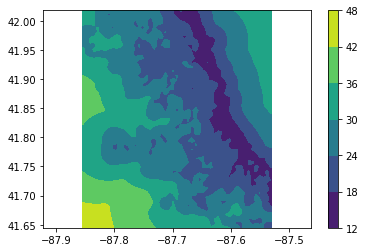

In [5]:
testX = testX[testX.columns.difference(['geometry'])]
TX = scaler.transform(testX[X.columns])
xx = np.linspace(lonmin,lonmax,51)
yy = np.linspace(latmin,latmax,51)
YY = lin.predict(TX)
testY = YY.reshape(51,51).transpose()
plt.contourf(xx,yy,testY,5,alpha=1.0)
plt.axis('equal')
plt.colorbar()
plt.show()

/Users/ianbakst/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ianbakst/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ianbakst/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


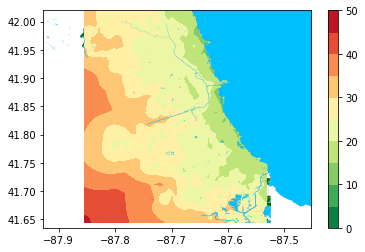

In [17]:
from descartes import PolygonPatch
import pysal as ps
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon as mpl_Polygon
from matplotlib.collections import PatchCollection
shapefile = 'water/chicago_latlon.shp'
parkshape = 'parks/chicago_parks1.shp'
forestshape = 'forest/forest.shp'
df_map_elements = gpd.GeoDataFrame.from_file(shapefile)
df_map_elements_p = gpd.GeoDataFrame.from_file(parkshape)
df_map_elements_f = gpd.GeoDataFrame.from_file(forestshape)

df_map_elements["mpl_polygon"] = np.nan
df_map_elements['mpl_polygon'] = df_map_elements['mpl_polygon'].astype(object)
df_map_elements_p['mpl_polygon'] = np.nan
df_map_elements_p['mpl_polygon'] = df_map_elements_p['mpl_polygon'].astype(object)
df_map_elements_f['mpl_polygon'] = np.nan
df_map_elements_f['mpl_polygon'] = df_map_elements_f['mpl_polygon'].astype(object)

for self_index, self_row_df in df_map_elements.iterrows():
    m_polygon = self_row_df['geometry']
    poly=[]
    if m_polygon.geom_type == 'MultiPolygon':
        for pol in m_polygon:
            poly.append(PolygonPatch(pol))
    else:
        poly.append(PolygonPatch(m_polygon))
    df_map_elements.set_value(self_index, 'mpl_polygon', poly)
    
for self_index, self_row_df in df_map_elements_f.iterrows():
    m_polygon = self_row_df['geometry']
    poly=[]
    if m_polygon.geom_type == 'MultiPolygon':
        for pol in m_polygon:
            poly.append(PolygonPatch(pol))
    else:
        poly.append(PolygonPatch(m_polygon))
    df_map_elements_f.set_value(self_index, 'mpl_polygon', poly)

for self_index, self_row_df in df_map_elements_p.iterrows():
    m_polygon = self_row_df['geometry']
    poly=[]
    if m_polygon.geom_type == 'MultiPolygon':
        for pol in m_polygon:
            poly.append(PolygonPatch(pol))
    else:
        poly.append(PolygonPatch(m_polygon))
    df_map_elements_p.set_value(self_index, 'mpl_polygon', poly)

dict_mapindex_mpl_polygon = df_map_elements['mpl_polygon'].to_dict()
dict_mapindex_mpl_polygon_p = df_map_elements_p['mpl_polygon'].to_dict()
dict_mapindex_mpl_polygon_f = df_map_elements_f['mpl_polygon'].to_dict()

fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon_p.items():
    p = PatchCollection(patches,color='darkgreen',lw=0.01,edgecolor='k')
    ax.add_collection(p)
for c_l ,patches in dict_mapindex_mpl_polygon_f.items():
    p = PatchCollection(patches,color='darkgreen',lw=0.01,edgecolor='k')
    ax.add_collection(p)

cfig = plt.contourf(xx,yy,testY,5,alpha=1,cmap='RdYlGn_r',levels=np.arange(0,55,5))
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    p = PatchCollection(patches,color='deepskyblue',lw=0.01,edgecolor='k')
    ax.add_collection(p)
cfig.set_clim(0, 50)
plt.colorbar(cfig)
plt.axis('equal')
plt.xlim(-87.85,-87.531)
plt.ylim(41.635,42.02)
plt.savefig('map.png',dpi=300)

In [180]:
dskey = '6864d54f724e54e7c3ae08094f523ff0'
chicago = forecast(dskey, 41.95, -87.80)

In [184]:
for day in chicago.daily:
    print(day.temperature)

AttributeError: 'DataPoint' object has no attribute 'temperature'

In [2]:
filename = 'lin_scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))
load_model = pickle.load(open(filename, 'rb'))

In [192]:
ts=1569474000
print(dt.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2019-09-26 05:00:00


In [247]:
t = pd.to_datetime('2019-09-27').isoformat()
print(t)
CHICAGO = dskey, 41.95, -87.80
backlog = forecast(*CHICAGO,time = t)
backlog.daily

2019-09-27T00:00:00


IndexError: list index out of range

In [225]:
for day in backlog.daily:
    print(dt.datetime.utcfromtimestamp(day.temperature).strftime('%Y-%m-%d %H:%M:%S'))

AttributeError: 'DataPoint' object has no attribute 'temperature'

In [31]:
geo_data.columns

Index(['Unnamed: 0', 'year', 'week', 'TEST ID', 'BLOCK', 'trap', 'TRAP_TYPE',
       'date', 'num', 'RESULT', 'SPECIES', 'lat', 'lon', 'LOCATION', 'Wards',
       'tract', 'zip', 'community', 'ward', 'geometry', 'd_water', 'd_park',
       'd_lm', 'TH0', 'TL1', 'Tmax', 'Tmin', 'prec'],
      dtype='object')

In [256]:
tp = (dt.date.today() + pd.DateOffset(-1)).isoformat()

In [20]:
def get_weather(input_date):
    date = (pd.to_datetime(input_date)).date()
    dskey = '6864d54f724e54e7c3ae08094f523ff0'
    CHICAGO = dskey, 41.95, -87.80
    deltaT = (date - dt.date.today()).days
    prec = 0.0
    Tmax = 0.0
    Tmin = 100.0
    TH0 = 0.0
    TL1 = 0.0
    if deltaT > 0:
        fore_cast = forecast(*CHICAGO)
        TH0 = fore_cast.daily[deltaT].temperatureHigh
        TL1 = fore_cast.daily[deltaT-1].temperatureLow
        for i in range(deltaT):
            Tmax = max([fore_cast.daily[i].temperatureHigh, Tmax])
            Tmin = min([fore_cast.daily[i].temperatureLow, Tmin])
            prec += fore_cast.daily[i].precipIntensityMax
    elif deltaT == 0:
        fore_cast = forecast(*CHICAGO)
        TH0 = fore_cast.daily[deltaT].temperatureHigh
        Tmax = TH0
        Tmin = fore_cast.daily[deltaT].temperatureLow
    
    N = 10 - deltaT
    if N > 10:
        N = 10
    for i in range(N):
        bt = (dt.date.today() + pd.DateOffset(deltaT - i)).isoformat()
        backDay = forecast(*CHICAGO, time = bt)
        if deltaT <= 0:
            if i == 0:
                TH0 = backDay.daily[0].temperatureHigh
            elif i == 1:
                TL1 = backDay.daily[0].temperatureLow
        Tmax = max([Tmax,backDay.daily[0].temperatureHigh])
        Tmin = min([Tmin,backDay.daily[0].temperatureLow])
        prec += backDay.daily[0].precipIntensityMax
    A={}
    A['TH0']= TH0
    A['TL1']= TL1
    A['Tmax']= Tmax
    A['Tmin']= Tmin
    A['prec']= prec
    return A


In [21]:
tp = (dt.date.today() + pd.DateOffset(-1)).isoformat()
A = get_weather(tp)

HTTPError: Bad response

In [270]:
def build_input(date):
    A = get_weather(date)
    GD = pd.read_csv('gridpoints.csv')
    GD['TH0'] = A['TH0']
    GD['TL1'] = A['TL1']
    GD['Tmax'] = A['Tmax']
    GD['Tmin'] = A['Tmin']
    GD['prec'] = A['prec']
    return GD

In [276]:
GD = build_input(tp)
GD

,Unnamed: 0,lat,lon,d_water,d_park,TH0,TL1,Tmax,Tmin,prec
0,0,41.644720,-87.854473,0.123963,0.140206,79.25,64.14,84.25,56.75,0.3664
1,1,41.652182,-87.854473,0.121492,0.136243,79.25,64.14,84.25,56.75,0.3664
2,2,41.659643,-87.854473,0.119437,0.129447,79.25,64.14,84.25,56.75,0.3664
3,3,41.667105,-87.854473,0.117814,0.122728,79.25,64.14,84.25,56.75,0.3664
4,4,41.674567,-87.854473,0.116645,0.116101,79.25,64.14,84.25,56.75,0.3664
...,...,...,...,...,...,...,...,...,...,...
2596,2596,41.987954,-87.531060,0.000000,0.101704,79.25,64.14,84.25,56.75,0.3664
2597,2597,41.995416,-87.531060,0.000000,0.103391,79.25,64.14,84.25,56.75,0.3664
2598,2598,42.002878,-87.531060,0.000000,0.105578,79.25,64.14,84.25,56.75,0.3664
2599,2599,42.010339,-87.531060,0.000000,0.108235,79.25,64.14,84.25,56.75,0.3664


In [302]:
def runmodel(date):
    filename = 'data/lin_model.sav'
    lin = pickle.load(open(filename, 'rb'))
    testX = build_input(date)[['lat','lon','TH0','TL1','Tmax','Tmin']]
    #testX = build_input(date)[['lat','lon','d_water','d_park','TH0','TL1','Tmax','Tmin','prec']]
    TT = lin.predict(testX)
    res = pd.DataFrame()
    res['lat'] = testX['lat']
    res['lon'] = testX['lon']
    res['M'] = TT
    lonmin = min(res['lon'])
    lonmax = max(res['lon'])
    lonmin = min(res['lat'])
    lonmax = max(res['lat'])
    A={}
    A['io'] = res
    A['xx'] = np.linspace(lonmin,lonmax,51)
    A['yy'] = np.linspace(lonmin,lonmax,51)
    A['MM'] = res['M'].values.reshape(51,51).transpose()
    return A

In [306]:
A = runmodel(tp)

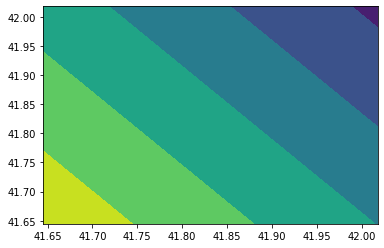

In [307]:
plt.contourf(A['xx'],A['yy'],A['MM'],5,alpha=1.0)

In [298]:
res['M'].values.reshape()

TypeError: reshape() takes exactly 1 argument (0 given)

In [339]:
def get_cv_score_linear_model(X, yin):
    LModel = LinearRegression()
    scaler = RobustScaler()
    pipe = Pipeline(steps=[('scaler', scaler), ('linear', LModel)])
    cv_results = cross_validate(pipe, X, yin, cv = 5, n_jobs = -1,
                                scoring = ('r2', 'neg_mean_absolute_error'),
                                verbose = 0)

    mae_mean_score = -cv_results['test_neg_mean_absolute_error'].mean()
    r2_mean_score = -cv_results['test_r2'].mean()
    regr = LinearRegression()
    pipe = Pipeline(steps=[('scaler', scaler), ('linear', regr)])
    pipe.fit(X, yin)
    
    return mae_mean_score, r2_mean_score, pipe

In [340]:
a,b,pipe = get_cv_score_linear_model(trainX,trainy)

In [23]:
import requests
resp=requests.get('https://api.darksky.net/forecast/'+dskey+'/42.3601,-71.0589')

In [25]:
resp.text

'{"code":403,"error":"daily usage limit exceeded"}'

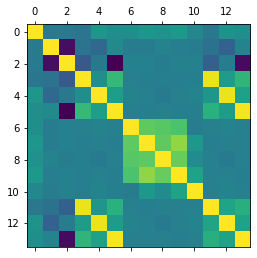

In [37]:
plt.matshow(feature_data.corr())
plt.show()

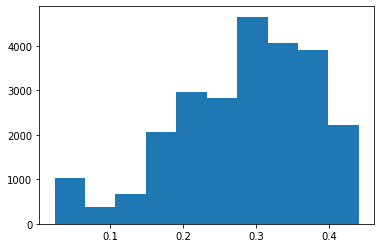

In [43]:
plt.hist(feature_data['sqrt_dl'])
plt.show()

In [4]:
crs = {'init': 'epsg:4326'}
geogrid = pd.read_csv('gridpoints.csv')
water_map = gpd.read_file('water/chicago_latlon.shp')
lake_MI = water_map[water_map.NAME == 'LAKE MICHIGAN']

geometry = [Point(xy) for xy in zip(geogrid.lon,geogrid.lat)]
grid = gpd.GeoDataFrame(geogrid, crs = crs, geometry = geometry)
grid = grid.reset_index(drop=False)

for i,point in grid.iterrows():
    for j,mi in lake_MI.iterrows():
        grid.loc[i,'d_lm'] = point['geometry'].distance(mi['geometry'])


In [5]:
grid.to_csv('gridlake.csv')

In [ ]:
import numpy as np 
import pandas as pd
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pickle

def runmodel(date):
    filename = 'data/lin_model.sav'
    lin = pickle.load(open(filename, 'rb'))
    testX = build_input(date)
    TT = lin.predict(testX)
    res = pd.DataFrame({'lat':testX['lat'],'lon':testY['lon'],'M':TT})
    map_plot(res)
    return

def bin_output(A,div=5):
    B = np.ceil(div*A)
    return B

def map_plot(res):
    xx = res['lon']
    yy = res['lat']
    M = res['M']
    plt.contourf(xx,yy,M,5,alpha=1.0)
    plt.axis('equal')
    plt.colorbar()
    plt.savefig('flaskapp/static/map.png',dpi=200)
    return
def get_weather(input_date):
    date = (pd.to_datetime(input_date)).date()
    dskey = '6864d54f724e54e7c3ae08094f523ff0'
    CHICAGO = dskey, 41.95, -87.80
    deltaT = (date - dt.date.today()).days
    prec = 0.0
    Tmax = 0.0
    Tmin = 100.0
    TH0 = 0.0
    TL1 = 0.0
    if deltaT > 0:
        fore_cast = forecast(*CHICAGO)
        TH0 = fore_cast.daily[deltaT].temperatureHigh
        TL1 = fore_cast.daily[deltaT-1].temperatureLow
        for i in range(deltaT):
            Tmax = max([fore_cast.daily[i].temperatureHigh, Tmax])
            Tmin = min([fore_cast.daily[i].temperatureLow, Tmin])
            prec += fore_cast.daily[i].precipIntensityMax
    elif deltaT == 0:
        fore_cast = forecast(*CHICAGO)
        TH0 = fore_cast.daily[deltaT].temperatureHigh
        Tmax = TH0
        Tmin = fore_cast.daily[deltaT].temperatureLow

    N = 10 - deltaT
    if N > 10:
        N = 10
    for i in range(N):
        bt = (dt.date.today() + pd.DateOffset(deltaT - i)).isoformat()
        backDay = forecast(*CHICAGO, time = bt)
        if deltaT <= 0:
            if i == 0:
                TH0 = backDay.daily[0].temperatureHigh
            elif i == 1:
                TL1 = backDay.daily[0].temperatureLow
        Tmax = max([Tmax,backDay.daily[0].temperatureHigh])
        Tmin = min([Tmin,backDay.daily[0].temperatureLow])
        prec += backDay.daily[0].precipIntensityMax
    A={}
    A['TH0']= TH0
    A['TL1']= TL1
    A['Tmax']= Tmax
    A['Tmin']= Tmin
    A['prec']= prec
    return A

def build_input(date):
    A = get_weather(date)
    GD = pd.read_csv('data/gridpoints.csv')
    GD['TH0'] = A['TH0']
    GD['TL1'] = A['TL1']
    GD['Tmax'] = A['Tmax']
    GD['Tmin'] = A['Tmin']
    GD['prec'] = A['prec']
    return GD